In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.VAE import LinearVAE,SGAE

In [2]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

## SGAE

In [4]:
model = SGAE(28*28,28*28,[256,64,256]).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [5]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output = model(data)
            reconLoss = BCE(output, data)
            loss = reconLoss
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [6]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 42%|████▏     | 25/59 [00:02<00:02, 12.31batch/s,  Epoch: 25 	Total Loss: 17.685724	Reconstruction Loss: 17.685724	 lr: 0.01000000]


KeyboardInterrupt: 

In [7]:
x=model(torch.ones((1,784),dtype=torch.float32,device='cuda'))

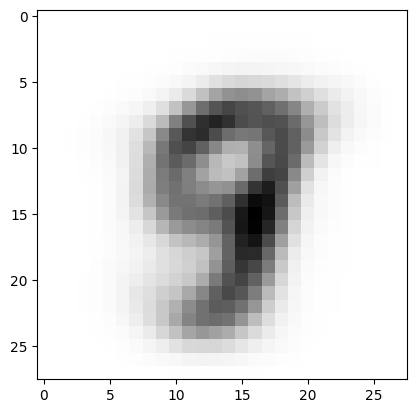

In [70]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [74]:
img0 = next(iter(train_loader))[0][0]

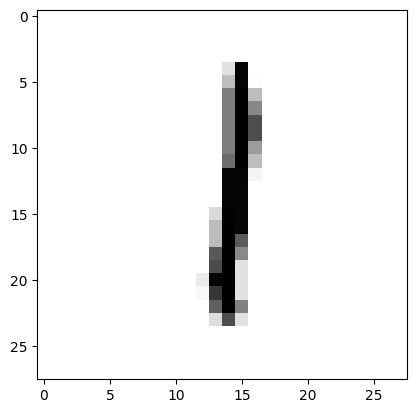

In [75]:
plt.imshow(img0[0], cmap='Greys')

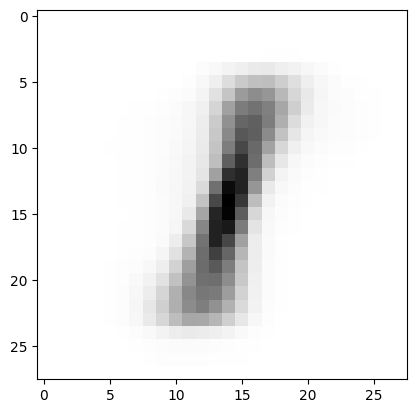

In [76]:
output, _, _ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

## Only BCE

In [6]:
model =  LinearVAE(encoder1, decoder1, 128, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [7]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = BCE(output, data)
            loss = reconLoss
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [8]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 59/59 [00:04<00:00, 12.42batch/s,  Epoch: 200 	Total Loss: 0.081400	Reconstruction Loss: 0.081400	 lr: 1.00000000]


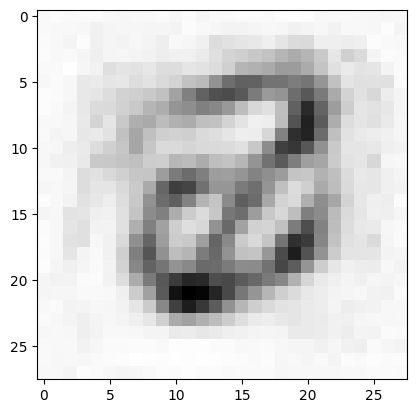

In [10]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [11]:
img0 = next(iter(train_loader))[0][0]

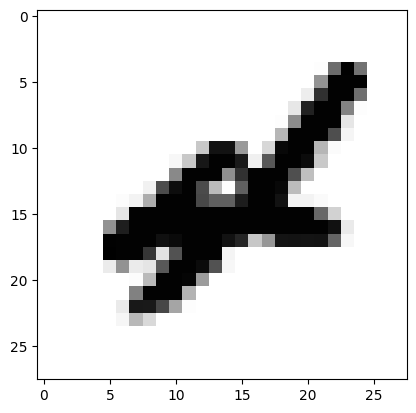

In [12]:
plt.imshow(img0[0], cmap='Greys')

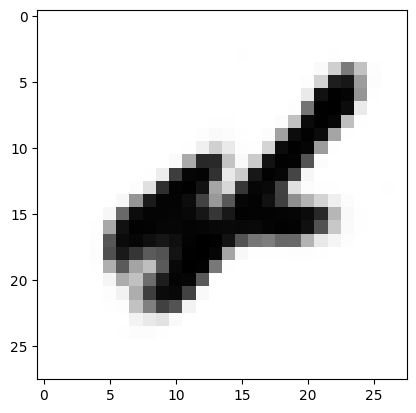

In [13]:
output, _, _ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

In [14]:
testBatch0=next(iter(train_loader))[0]

In [16]:
_,testMu,testLogvar=model(testBatch0.view(-1,28*28).cuda())

In [17]:
testMu

tensor([[16.6421,  6.6377, -5.6243,  ...,  4.5057, -2.5437, -0.4899],
        [ 7.3226,  2.5680, -5.1583,  ..., -2.2315, -4.4619, -3.2795],
        [-6.2674,  5.1949, -5.4320,  ...,  2.5350,  4.1184, -3.8398],
        ...,
        [-6.8060,  0.4432,  1.3288,  ...,  3.5307, -5.0770, -2.4892],
        [ 7.2060, -4.0303, -2.7953,  ...,  2.0946,  1.4376,  3.4276],
        [ 7.2078, -5.5857, -2.6517,  ..., -3.9898, 11.4325, -5.2647]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [18]:
from sklearn.mixture import GaussianMixture
gm=GaussianMixture(10)

In [22]:
gm.fit(testMu.detach().cpu())

GaussianMixture(n_components=10)

In [23]:
gm.means_

array([[ 7.15132463e+00, -7.12238056e-01, -2.92221215e+00,
         6.13318557e-01, -5.44238383e-01,  7.76435800e+00,
         4.69089164e+00,  5.18205137e+00, -2.23015837e+00,
         2.47707280e+00,  1.01401525e-01, -1.43885065e+00,
        -3.41118978e+00, -4.51757784e-01,  1.34928019e+00,
        -4.22867755e-02,  1.55901429e+00,  1.65287173e+00,
        -9.19230563e-01, -6.69156110e-01,  2.51598556e+00,
         8.00572273e-02, -9.68093843e-01, -2.81860967e-01,
        -1.84898162e+00, -1.00449900e+00,  2.89582116e+00,
        -2.60291953e+00, -2.29162927e-01,  4.20732192e+00,
        -3.16015141e-01,  1.09629397e+00,  9.60188756e+00,
        -3.96340010e+00, -6.64579518e-02, -5.57171757e-01,
         1.05004994e+00, -1.73643032e+00, -5.41676591e+00,
         2.30947069e+00,  9.57693091e-01,  5.05044577e-03,
        -2.21618843e+00,  3.33858120e-01,  2.39755895e+00,
         2.87443453e+00, -3.81556784e-01,  5.25245734e+00,
        -3.63691764e+00, -2.10583743e+00, -9.87353160e-0

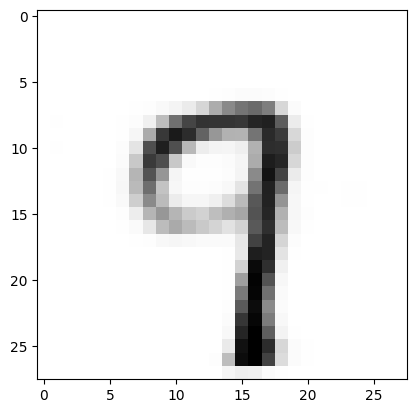

In [35]:
gmMeanOutput=model.sample(torch.tensor(gm.means_[0],dtype=torch.float32).cuda())
plt.imshow(gmMeanOutput.cpu().detach().view(28, 28), cmap='Greys')

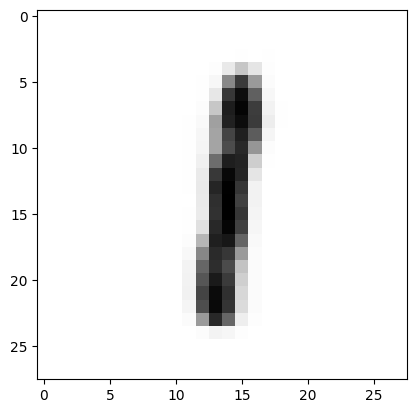

In [36]:
gmMeanOutput=model.sample(torch.tensor(gm.means_[1],dtype=torch.float32).cuda())
plt.imshow(gmMeanOutput.cpu().detach().view(28, 28), cmap='Greys')

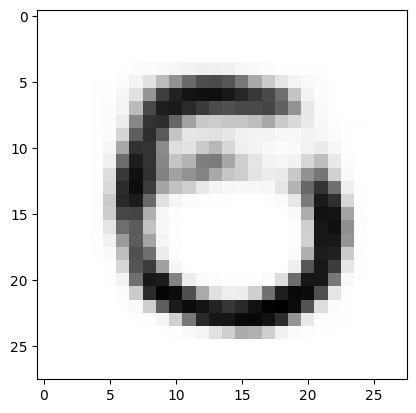

In [37]:
gmMeanOutput=model.sample(torch.tensor(gm.means_[2],dtype=torch.float32).cuda())
plt.imshow(gmMeanOutput.cpu().detach().view(28, 28), cmap='Greys')

## KLD and L1

In [6]:
model =  LinearVAE(encoder1, decoder1, 128, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [7]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = L1Loss(output, data)
            loss = reconLoss + KLD(mu, log_var)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [8]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 81%|████████▏ | 48/59 [00:03<00:00, 13.48batch/s,  Epoch: 35 	Total Loss: 0.125190	Reconstruction Loss: 0.125186	 lr: 0.00100000]


KeyboardInterrupt: 

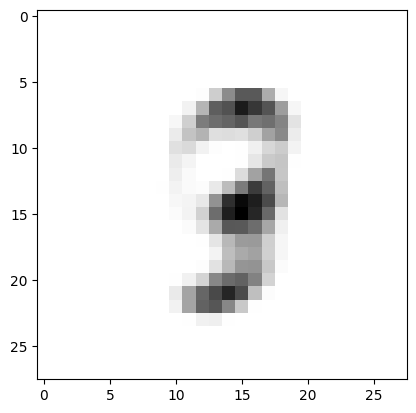

In [9]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [10]:
img0 = next(iter(train_loader))[0][0]

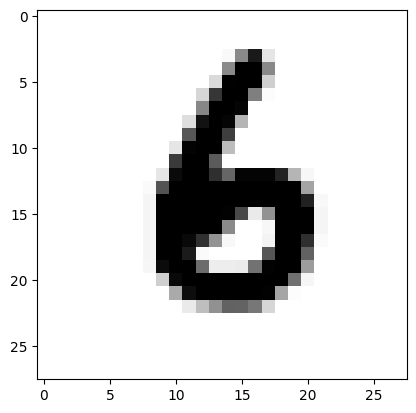

In [11]:
plt.imshow(img0[0], cmap='Greys')

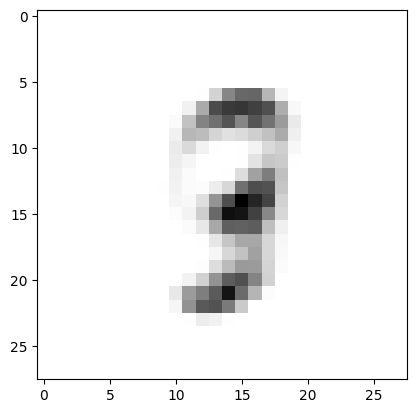

In [12]:
output, _, _ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')